# Import Packages

In [1]:
from typing import Any, Mapping, Optional, Tuple, Union, Dict

import ee
import pandas as pd
import time
from tqdm.auto import tqdm

from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

In [ ]:
!pip install -q rasterio
import rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 41.7 MB/s eta 0:00:00


In [2]:
# mount the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd "/content/gdrive/MyDrive/master_thesis/"

/content/gdrive/MyDrive/master_thesis


# User written functions


## General functions

In [ ]:
def compute_stats(img, data_type = "LS"):
    n_bands = img.shape[2]
    basic_stats = {}
    for i in range(n_bands):
      if data_type == "LS":
        basic_stats[i] = get_basic_stats_ls(img[:,:,i])
      else:
        basic_stats[i] = get_basic_stats_rs(img[:,:,i])
    return basic_stats

def get_basic_stats_ls(band):
    stats = {}
    stats['min'] = np.nanmin(band)
    stats['max'] = np.nanmax(band)
    stats['mean'] = np.nanmean(band)
    stats['median'] = np.nanmedian(band)
    stats['sum'] = np.nansum(band)
    stats['sum_of_squares'] = np.nansum(band**2)
    stats['std'] = np.nanstd(band)
    stats['n_negative'] = np.nansum(band < 0)
    stats['n_over_1'] = np.nansum(band > 1)
    stats['n_not_na'] = np.count_nonzero(~np.isnan(band))
    stats['n_na'] = np.count_nonzero(np.isnan(band))
    stats['n'] = len(band.flatten())
    return stats

def get_basic_stats_rs(band):
    stats = {}
    masked_band = band[((band > -888) | (np.isnan(band)))].flatten() # -888 indicates 'no cropland' and -999 indicates 'water'
    stats['min'] = np.nanmin(masked_band)
    stats['max'] = np.nanmax(masked_band)
    stats['mean'] = np.nanmean(masked_band)
    stats['median'] = np.nanmedian(masked_band)
    stats['sum'] = np.nansum(masked_band)
    stats['sum_of_squares'] = np.nansum(masked_band**2)
    stats['std'] = np.nanstd(masked_band)
    stats['n_negative'] = np.nansum(masked_band < 0)
    stats['n_over_1'] = np.nansum(masked_band > 1)
    stats['n_not_na'] = np.count_nonzero(~np.isnan(band))
    stats['n_na'] = np.count_nonzero(np.isnan(band))
    stats['n'] = band.shape[0] * band.shape[1]
    stats['n_water'] = np.sum(band == -999)
    stats['n_no_cropland'] = np.sum(band == -888)
    return stats

In [ ]:
def load_img(file_path):
  # extract the file name
  file_name = file_path.split("/")[-1]

  # load the image
  img = import_tif_file(file_path)

  # center crop the image
  img = center_crop_img(img)
  
  # if it is a Landsat Image reorder the first three channels
  is_ls = 'LS' in file_name
  if is_ls:
    img = reorder_rgb(img)
  
  # if it is a RS image, fix the WSF image
  is_rs = 'RS' in file_name
  if is_rs:
    img = fix_wsf(img, info)
  
  return img

def import_tif_file(geotiff_file_path, is_ls = False):
    with rasterio.open(geotiff_file_path) as src:
      # Read the image data.
      src_img = src.read()
    img = src_img.transpose(1,2,0) # rearrange the dimensions of the np array
    return img

def reorder_rgb(img):
    '''
    The order of the channels in GEE is Blue, Green, Red
    Reorder the imgage to RGB.
    '''
    n_channels = img.shape[2] 
    bgr = img[:,:,:3]
    rgb = np.stack([img[:,:,2], img[:,:,1], img[:,:,0]], axis = 2)
    if n_channels > 3:
      oth = img[:,:,3:]
      img = np.concatenate((rgb,oth), axis = 2)
    else: img = rgb
    return img


# centers and crops the image to a 255 x 255 pixel image
def center_crop_img(img, img_width = 255, img_height = 255):
    act_h = img.shape[0]
    act_w = img.shape[1]
    n_channles = img.shape[2]
    
    h_diff = act_h - img_height
    w_diff = act_w - img_width
    
    # sets the pixel value where to start
    h_start = int(h_diff / 2)
    w_start = int(w_diff / 2)
    
    # sets the end of the pixel where to end
    h_end = h_start + img_height
    w_end = w_start + img_width
    
    cropped_img = img[h_start:h_end, w_start:w_end, :]
    return cropped_img

def count_na_pixels(img):
    '''
    count the number of NA pixels in each image. 
    Returns a dictionary with the number of NA pixels per image band
    '''
    n_bands = img.shape[2]
    na_pixels = {}
    na_pixels['n_pixels'] = len(img[:,:,0].flatten())
    for i in range(n_bands):
        na_pixels[i] = sum(np.isnan(img[:,:,i].flatten()))
    return na_pixels

def fix_wsf(img, info):
    img[:,:,5] = np.nan_to_num(img[:,:,5], nan = 0)
    is_pop = (img[:,:,5] < (info.start_year + 1)) & (img[:,:,5] > 1)
    not_yet_pop = img[:,:,5] > info.start_year
    img[:,:,5][is_pop] = 1
    img[:,:,5][not_yet_pop] = 0
    return img


def aggregate_band_stats(band_stats, flagged_ids = []):
    summary_band_stats = {}
    for band in band_stats.keys():
      summary_band_stats[band] = aggregate_band(band_stats[band], flagged_ids)
    return summary_band_stats

def aggregate_band(band_stats_band, flagged_ids):
    res = {}
    if len(flagged_ids) == 0:
      aux = band_stats_band
    else:
      mask = np.array([i in flagged_ids for i in band_stats_band.unique_id])
      aux = band_stats_band.loc[~mask].reset_index(drop = True)
    res['min'] = np.min(aux['min'])
    res['max'] = np.max(aux['max'])
    res['mean'] = np.mean(aux['mean'])
    res['median'] = np.median(aux['median'])
    res['sum'] = np.sum(aux['sum'])
    res['sum_of_squares'] = np.sum(aux['sum_of_squares'])
    res['N'] = sum(aux['n'])
    res['N_not_na'] = sum(aux['n_not_na'])
    res['std'] = calc_std(res['sum'], res['sum_of_squares'], res['N'])
    return res

def calc_std(sm, ss, n):
    vr = ss/n - (sm/n)**2
    return np.sqrt(vr)

## print functions


In [ ]:
def print_summary(summary_band_stats, band_name_dict):
    for band, stats in summary_band_stats.items():
      print(f"{band}:\t min:{stats['min']:.5f}\t max:{stats['max']:.5f}\t mean:{stats['mean']:.5f}\t std:{stats['std']:.5f}\t{band_name_dict[band]}")

def print_min_max(img):
    n_channels = img.shape[2]
    for i in range(n_channels):
      flat_img = img[:,:,i].flatten()
      img_min = min(flat_img)
      img_max = max(flat_img)
      print(f"\n Channel {i}")
      print(img_min)
      print(img_max)

def print_band_stats(band_stats, band_name_dict):
  for band in band_stats.keys():
    aux = band_stats[band]['n_na']
    aux_neg = band_stats[band]['n_negative']
    aux_pos = band_stats[band]['n_over_1']
    print(f"\nBand {band_name_dict[band]} sum of NA pixels: {sum(aux)}")
    print(f"Band {band_name_dict[band]} number of images with NA pixels: {np.sum(aux > 0)}")
    print(f"Band {band_name_dict[band]} mean number of NA pixels: {np.mean(aux)}")
    print(f"Band {band_name_dict[band]} number of images with negative pixels: {np.sum(aux_neg > 0)}")
    print(f"Band {band_name_dict[band]} number of negative pixels: {np.sum(aux_neg)}")
    print(f"Band {band_name_dict[band]} mean number of negative pixels: {np.mean(aux_neg)}")
    print(f"Band {band_name_dict[band]} median number of negative pixels: {np.median(aux_neg)}")
    print(f"Band {band_name_dict[band]} max number of negative pixels: {np.max(aux_neg)}")
    print(f"Band {band_name_dict[band]} number of images with pixels > 1: {np.sum(aux_pos > 0)}")

## plot functions


In [ ]:
def plot_most_affected_imgs(lsms_df, band_stats, band_nr, by = 'n_na', lower = 0, upper = 100):
  most_affected = band_stats[band_nr].sort_values(by = by, ascending = False).iloc[lower:upper].reset_index(drop = True).copy()
  most_affected = pd.merge(most_affected, lsms_df[['unique_id','file_path']], on = 'unique_id')
  most_affected_ids = list(most_affected.unique_id)
  most_affected_Na_count = list(most_affected.n_na)
  most_affected_paths = list(most_affected.file_path)

  fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(50, 50))
  for i, ax in enumerate(axs.flat):
    img = load_img(most_affected_paths[i])
    ax.imshow(img[:,:,2], cmap = 'gray')
    ax.set_title(f'{most_affected_ids[i]}-count:{most_affected_Na_count[i]}')
  plt.show()

# Landsat Images

## Extract statistics from image





In [ ]:
# set parameters
data_type = 'LS' # LS or RS
lsms_path = "Data/lsms_data/labels_cluster_v1.csv"
raw_dir = f"Data/{data_type}/{data_type}_raw"

band_name_dict = dict(zip(list(range(7)),['Red', 'Green', 'Blue', 'NIR',
                                          'SWIR1', 'SWIR2', 'Temp']))

In [ ]:
# load the LSMS_data
lsms_df = pd.read_csv(lsms_path)

# add the file path to the lsms_df
lsms_df['file_name'] = [f'{data_type}_{i}.tif' for i in lsms_df['unique_id']]
lsms_df['file_path'] = [f'{raw_dir}/{data_type}_{lsms_df.country[i]}_{lsms_df.series[i]}_{lsms_df.start_year[i]}/{lsms_df.file_name[i]}' for i in range(len(lsms_df))]

In [ ]:
# check whether all files have been downloaded

# list all files and store its paths and file names in one list
raw_folders = os.listdir(raw_dir)
files = [os.listdir(raw_dir+"/"+folder) for folder in raw_folders]
file_paths = [[raw_dir+"/"+raw_folders[i]+"/"+f for f in files[i]] for i in range(len(raw_folders))]

file_paths = [i for sublist in file_paths for i in sublist]
files = [i for sublist in files for i in sublist]

# check whether for each unique_id there is an image
downloaded = [f in files for f in lsms_df['file_name']]
print(f"{sum(downloaded)} files have been sucessfully downloaded")
print(f"{len(lsms_df) - sum(downloaded)} files are missing")

7141 files have been sucessfully downloaded
0 files are missing


In [ ]:
# extract basic information
# this loads every image, and computes basic statistics on that image
# the result is a nested dictionary with two subdictionaries:
# the key to the first is the unique_id
# the key to the second is the band number (from 0 - 12)
# the key to the third is the statistic of interest (e.g. max, mean etc. )
unique_id_stats = {}
for idx, info in tqdm(lsms_df.iterrows(), total = len(lsms_df)):
    # load and preprocess the image
    img = load_img(info.file_path)

    # print the id if any band has only NA values
    n_bands = img.shape[2]
    nas = np.isnan(img).all(axis = 0).all(axis = 0)
    if any(nas):
      print(info.unique_id)
      img_band_with_nas = np.where(nas == True)[0][0]
      print(f"Only NAs in image band {img_band_with_nas}: {band_name_dict[img_band_with_nas]}")

    # Get basic statistics of the image
    basic_stats = compute_stats(img, data_type = data_type)

    # store the basic stats of the image
    unique_id_stats[info.unique_id] = basic_stats

  0%|          | 0/7141 [00:00<?, ?it/s]

mwi_30212492_2010
Only NAs in image band 5: SWIR2


<ipython-input-9-232356493a9e>:13: RuntimeWarning: All-NaN slice encountered
  stats['min'] = np.nanmin(band)
<ipython-input-9-232356493a9e>:14: RuntimeWarning: All-NaN slice encountered
  stats['max'] = np.nanmax(band)
<ipython-input-9-232356493a9e>:15: RuntimeWarning: Mean of empty slice
  stats['mean'] = np.nanmean(band)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


mwi_30711684_2010
Only NAs in image band 5: SWIR2
mwi_31532674_2010
Only NAs in image band 5: SWIR2
tza_10314002_2010
Only NAs in image band 5: SWIR2
tza_15306001_2008
Only NAs in image band 5: SWIR2
uga_1130012_2009
Only NAs in image band 5: SWIR2
uga_1130012_2011
Only NAs in image band 5: SWIR2


In [ ]:
# Create a new dictionary, that contains statistics by band
# the band_stats is a dictionary where the band number (0-12) is the key
# and the value is a pandas dataframe containing the statistics for all images
# each row in the dataframe corresponds to one unique_id
ids = []
stats = []
# append every dictionary for each id to one list
for id, bnd_sts in unique_id_stats.items():
  ids.append(id)
  stats.append(bnd_sts)

# reorder dictionary by band (i.e. for each band gather information in one list)
band_stats = {}
for k in stats[0].keys():
  band_stats[k] = list(cls_sts[k] for cls_sts in stats)

# convert each band to a pd dataframe
for band_key in band_stats.keys():
  band_stats[band_key] = pd.json_normalize(band_stats[band_key])
  band_stats[band_key]['unique_id'] = ids

In [ ]:
# print the band stats
print_band_stats(band_stats, band_name_dict)


Band Red sum of NA pixels: 1446329
Band Red number of images with NA pixels: 654
Band Red mean number of NA pixels: 202.53872006721747
Band Red number of images with negative pixels: 213
Band Red number of negative pixels: 310669
Band Red mean number of negative pixels: 43.50497129253606
Band Red median number of negative pixels: 0.0
Band Red max number of negative pixels: 16632
Band Red number of images with pixels > 1: 167

Band Green sum of NA pixels: 1446329
Band Green number of images with NA pixels: 654
Band Green mean number of NA pixels: 202.53872006721747
Band Green number of images with negative pixels: 57
Band Green number of negative pixels: 1036
Band Green mean number of negative pixels: 0.14507772020725387
Band Green median number of negative pixels: 0.0
Band Green max number of negative pixels: 212
Band Green number of images with pixels > 1: 62

Band Blue sum of NA pixels: 1446343
Band Blue number of images with NA pixels: 654
Band Blue mean number of NA pixels: 202.54

In [ ]:
# aggregate the band statistics and print an overview
summary_band_stats = aggregate_band_stats(band_stats, flagged_ids = [])
print(f'Summary statistics based on all data including {len([])} flagged images and exluding any NA pixels')
print_summary(summary_band_stats, band_name_dict)

Summary statistics based on all data including 0 flagged images and exluding any NA pixels
0:	 min:-0.10763	 max:1.60221	 mean:0.09885	 std:0.04962	Red
1:	 min:-0.08403	 max:1.60221	 mean:0.08690	 std:0.03198	Green
2:	 min:-0.19678	 max:1.60221	 mean:0.05793	 std:0.02485	Blue
3:	 min:-0.04366	 max:1.60221	 mean:0.26093	 std:0.06606	NIR
4:	 min:-0.01627	 max:1.60221	 mean:0.23715	 std:0.08416	SWIR1
5:	 min:-0.19194	 max:1.60221	 mean:0.68028	 std:0.43513	SWIR2
6:	 min:150.00148	 max:372.99994	 mean:235.18523	 std:53.44878	Temp


In [ ]:
pth = f'Data/{data_type}/{data_type}_unique_id_stats.pkl'
with open(pth, 'wb') as f:
    pickle.dump(unique_id_stats, f)

In [ ]:
pth = f'Data/{data_type}/{data_type}_band_stats.pkl'
with open(pth, 'wb') as f:
    pickle.dump(band_stats, f)

## Summaries for the images 

In [ ]:
# load the LS_unique_id_stats file
pth = f'Data/{data_type}/{data_type}_unique_id_stats.pkl'
with open(pth, 'rb') as f:
    unique_id_stats = pickle.load(f)

# load the LS_band_stats file
pth = f'Data/{data_type}/{data_type}_band_stats.pkl'
with open(pth, 'rb') as f:
    band_stats = pickle.load(f)

In [ ]:
# print the band stats
print_band_stats(band_stats, band_name_dict)

clearly, the SWIR2 band is most affected by NA pixels, thus just ignore that band in the analysis. For the analysis only include RGB, NIR, SWIR1, TEMP1

In [ ]:
# print the number of images that are affected by at least one NA pixel in the Blue Channel
print(f"Number of images affected by NA pixels in the Blue channel {sum(band_stats[2]['n_na'] > 0)}")

# which country year pairs are most affected?
aux = band_stats[2].copy()
aux['country'] = [i[:3] for i in aux['unique_id']]
aux['year'] = [i[-4:] for i in aux['unique_id']]
aux = aux.loc[aux['n_na']>0].reset_index(drop = True)
print('\nNumber of images affected by NAs by country year')
print(pd.crosstab(aux['year'], aux.country))

## Plot most affected images

In [ ]:
plot_most_affected_imgs(lsms_df, band_stats, 2, 'n_na', 100, 200)

In [ ]:
plot_most_affected_imgs(lsms_df, band_stats, 2, 'n_na', 200, 300)

In [ ]:
plot_most_affected_imgs(lsms_df, band_stats, 2, 'n_na', 300, 400)

In [ ]:
plot_most_affected_imgs(lsms_df, band_stats, 0, 'n_over_1', 0, 100)

In [ ]:
plot_most_affected_imgs(lsms_df, band_stats, 0, 'n_negative', 0, 100)

In [ ]:
# flag images if they do not meet the data quality criteria:
flagged_df = band_stats['Blue'].sort_values(by = 'n_na', ascending = False).iloc[:300].reset_index(drop = True).copy()
flagged_ids = list(flagged_df.unique_id)
lsms_df['flagged'] = [i in flagged_ids for i in lsms_df['unique_id']]

## Flag the images with the highest number of missing values

In [ ]:
# load the LS_unique_id_stats file
pth = f'Data/{data_type}/{data_type}_unique_id_stats.pkl'
with open(pth, 'rb') as f:
    unique_id_stats = pickle.load(f)

# load the LS_band_stats file
pth = f'Data/{data_type}/{data_type}_band_stats.pkl'
with open(pth, 'rb') as f:
    band_stats = pickle.load(f)

In [ ]:
# flag an image if it includes more than 500 invalid i.e. NA pixels
flagged_ids = []
for id, info in unique_id_stats.items():
    nas = [stats['n_na'] for band, stats in info.items() if band != 5] # do not consider SWIR2 band (too many missing values)
    if any(np.array(nas) > 500):
      flagged_ids.append(id)
      unique_id_stats[id]['flagged'] = True
    else:
      unique_id_stats[id]['flagged'] = False

In [ ]:
# aggregate the band statistics and print an overview including all images (also the flagged ones)
summary_band_stats_all = aggregate_band_stats(band_stats, flagged_ids = [])
print(f'Summary statistics based on all data including {len(flagged_ids)} flagged images and exluding any NA pixels')
print_summary(summary_band_stats, band_name_dict)

# aggregate the band statistics and print an overview excluding flagged images
summary_band_stats_no_flag = aggregate_band_stats(band_stats, flagged_ids = flagged_ids)
print(f'\nSummary statistics excluding {len(flagged_ids)} flagged images and exluding any NA pixels')
print_summary(summary_band_stats, band_name_dict)

In [ ]:
raw_stats = {
    'flagged_ids': flagged_ids,
    'stats': summary_band_stats_no_flag,
    'stats_include_flagged': summary_band_stats_all
}

pth = f'Data/{data_type}/{data_type}_raw_stats.pkl'
with open(pth, 'wb') as f:
  pickle.dump(raw_stats, f)

# RS images

## Extract statistics from image





In [ ]:
# set parameters
data_type = 'RS' # LS or RS
lsms_path = "Data/lsms_data/labels_cluster_v1.csv"
raw_dir = f"Data/{data_type}/{data_type}_raw"

band_name_dict = dict(zip(list(range(12)),['NIGHTLIGHTS', 'NDVI_mean', 'NDVI_median', 'NDVI_cropland_mean', 
                                      'NDVI_cropland_median', 'WSF', 'NDWI_gao_mean', 'NDWI_gao_median', 
                                      'NDWI_McF_mean', 'NDWI_McF_median', 'LC_modis', 'LC_esa']))

In [ ]:
# load the LSMS_data
lsms_df = pd.read_csv(lsms_path)

# add the file path to the lsms_df
lsms_df['file_name'] = [f'{data_type}_{i}.tif' for i in lsms_df['unique_id']]
lsms_df['file_path'] = [f'{raw_dir}/{data_type}_{lsms_df.country[i]}_{lsms_df.series[i]}_{lsms_df.start_year[i]}/{lsms_df.file_name[i]}' for i in range(len(lsms_df))]

In [ ]:
# check whether all files have been downloaded

# list all files and store its paths and file names in one list
raw_folders = os.listdir(raw_dir)
files = [os.listdir(raw_dir+"/"+folder) for folder in raw_folders]
file_paths = [[raw_dir+"/"+raw_folders[i]+"/"+f for f in files[i]] for i in range(len(raw_folders))]

file_paths = [i for sublist in file_paths for i in sublist]
files = [i for sublist in files for i in sublist]

# check whether for each unique_id there is an image
downloaded = [f in files for f in lsms_df['file_name']]
print(f"{sum(downloaded)} files have been successfully downloaded")
print(f"{len(lsms_df) - sum(downloaded)} files are missing")

7141 files have been successfully downloaded
0 files are missing


In [ ]:
# extract basic information
# this loads every image, and computes basic statistics on that image
# the result is a nested dictionary with two subdictionaries:
# the key to the first is the unique_id
# the key to the second is the band number (from 0 - 12)
# the key to the third is the statistic of interest (e.g. max, mean etc. )
unique_id_stats = {}
for idx, info in tqdm(lsms_df.iterrows(), total = len(lsms_df)):
    # load and preprocess the image
    img = load_img(info.file_path)

    # print the id if any band has only NA values
    n_bands = img.shape[2]
    nas = np.isnan(img).all(axis = 0).all(axis = 0)
    if any(nas):
      print(info.unique_id)
      img_band_with_nas = np.where(nas == True)[0][0]
      print(f"Only NAs in image band {img_band_with_nas}:{band_name_dict[img_band_with_nas]}")

    # Get basic statistics of the image
    basic_stats = compute_stats(img, data_type = data_type)

    # store the basic stats of the image
    unique_id_stats[info.unique_id] = basic_stats

  0%|          | 0/7141 [00:00<?, ?it/s]

In [ ]:
# Create a new dictionary, that contains statistics by band
# the band_stats is a dictionary where the band number (0-12) is the key
# and the value is a pandas dataframe containing the statistics for all images
# each row in the dataframe corresponds to one unique_id
ids = []
stats = []
# append every dictionary for each id to one list
for id, bnd_sts in unique_id_stats.items():
  ids.append(id)
  stats.append(bnd_sts)

# reorder dictionary by band (i.e. for each band gather information in one list)
band_stats = {}
for k in stats[0].keys():
  band_stats[k] = list(cls_sts[k] for cls_sts in stats)

# convert each band to a pd dataframe
for band_key in band_stats.keys():
  band_stats[band_key] = pd.json_normalize(band_stats[band_key])
  band_stats[band_key]['unique_id'] = ids

In [ ]:
# print the band stats
print_band_stats(band_stats, band_name_dict)


Band NIGHTLIGHTS sum of NA pixels: 0
Band NIGHTLIGHTS number of images with NA pixels: 0
Band NIGHTLIGHTS mean number of NA pixels: 0.0
Band NIGHTLIGHTS number of images with negative pixels: 0
Band NIGHTLIGHTS number of negative pixels: 0
Band NIGHTLIGHTS mean number of negative pixels: 0.0
Band NIGHTLIGHTS median number of negative pixels: 0.0
Band NIGHTLIGHTS max number of negative pixels: 0
Band NIGHTLIGHTS number of images with pixels > 1: 2804

Band NDVI_mean sum of NA pixels: 0
Band NDVI_mean number of images with NA pixels: 0
Band NDVI_mean mean number of NA pixels: 0.0
Band NDVI_mean number of images with negative pixels: 66
Band NDVI_mean number of negative pixels: 5821
Band NDVI_mean mean number of negative pixels: 0.8151519395042711
Band NDVI_mean median number of negative pixels: 0.0
Band NDVI_mean max number of negative pixels: 2936
Band NDVI_mean number of images with pixels > 1: 0

Band NDVI_median sum of NA pixels: 0
Band NDVI_median number of images with NA pixels: 0

In [ ]:
# aggregate the band statistics and print an overview
summary_band_stats = aggregate_band_stats(band_stats, flagged_ids = [])
print(f'Summary statistics based on all data including {len([])} flagged images and exluding any NA pixels')
print_summary(summary_band_stats, band_name_dict)

Summary statistics based on all data including 0 flagged images and exluding any NA pixels
0:	 min:0.00000	 max:378.73523	 mean:1.42455	 std:5.19685	NIGHTLIGHTS
1:	 min:-0.15671	 max:0.64521	 mean:0.29552	 std:0.09948	NDVI_mean
2:	 min:-0.19010	 max:0.77543	 mean:0.27413	 std:0.12209	NDVI_median
3:	 min:-0.15671	 max:0.64521	 mean:0.29883	 std:0.16421	NDVI_cropland_mean
4:	 min:-0.19010	 max:0.77543	 mean:0.27671	 std:0.16767	NDVI_cropland_median
5:	 min:0.00000	 max:1.00000	 mean:0.15704	 std:0.36125	WSF
6:	 min:-0.19099	 max:0.50191	 mean:0.10575	 std:0.07599	NDWI_gao_mean
7:	 min:-0.19664	 max:0.56442	 mean:0.08802	 std:0.08040	NDWI_gao_median
8:	 min:-0.57991	 max:0.40066	 mean:-0.29633	 std:0.09832	NDWI_McF_mean
9:	 min:-0.70794	 max:0.37709	 mean:-0.29667	 std:0.13677	NDWI_McF_median
10:	 min:1.00000	 max:17.00000	 mean:11.19562	 std:2.30031	LC_modis
11:	 min:10.00000	 max:95.00000	 mean:31.46317	 std:18.01934	LC_esa


In [ ]:
pth = f'Data/{data_type}/{data_type}_unique_id_stats.pkl'
with open(pth, 'wb') as f:
    pickle.dump(unique_id_stats, f)

In [ ]:
pth = f'Data/{data_type}/{data_type}_band_stats.pkl'
with open(pth, 'wb') as f:
    pickle.dump(band_stats, f)

## Summaries for the images 

In [ ]:
# load the LS_unique_id_stats file
pth = f'Data/{data_type}/{data_type}_unique_id_stats.pkl'
with open(pth, 'rb') as f:
    unique_id_stats = pickle.load(f)

# load the LS_band_stats file
pth = f'Data/{data_type}/{data_type}_band_stats.pkl'
with open(pth, 'rb') as f:
    band_stats = pickle.load(f)

In [ ]:
# print the band stats
print_band_stats(band_stats, band_name_dict)


Band NIGHTLIGHTS sum of NA pixels: 0
Band NIGHTLIGHTS number of images with NA pixels: 0
Band NIGHTLIGHTS mean number of NA pixels: 0.0
Band NIGHTLIGHTS number of images with negative pixels: 0
Band NIGHTLIGHTS number of negative pixels: 0
Band NIGHTLIGHTS mean number of negative pixels: 0.0
Band NIGHTLIGHTS median number of negative pixels: 0.0
Band NIGHTLIGHTS max number of negative pixels: 0
Band NIGHTLIGHTS number of images with pixels > 1: 2804

Band NDVI_mean sum of NA pixels: 0
Band NDVI_mean number of images with NA pixels: 0
Band NDVI_mean mean number of NA pixels: 0.0
Band NDVI_mean number of images with negative pixels: 66
Band NDVI_mean number of negative pixels: 5821
Band NDVI_mean mean number of negative pixels: 0.8151519395042711
Band NDVI_mean median number of negative pixels: 0.0
Band NDVI_mean max number of negative pixels: 2936
Band NDVI_mean number of images with pixels > 1: 0

Band NDVI_median sum of NA pixels: 0
Band NDVI_median number of images with NA pixels: 0

# Testing Area


In [ ]:
np.set_printoptions(threshold=np.inf)
for row in img[:,:,2]:
    print('[', end='')
    for val in row:
        print(f'{val:.3f}', end='\t')
    print(']')

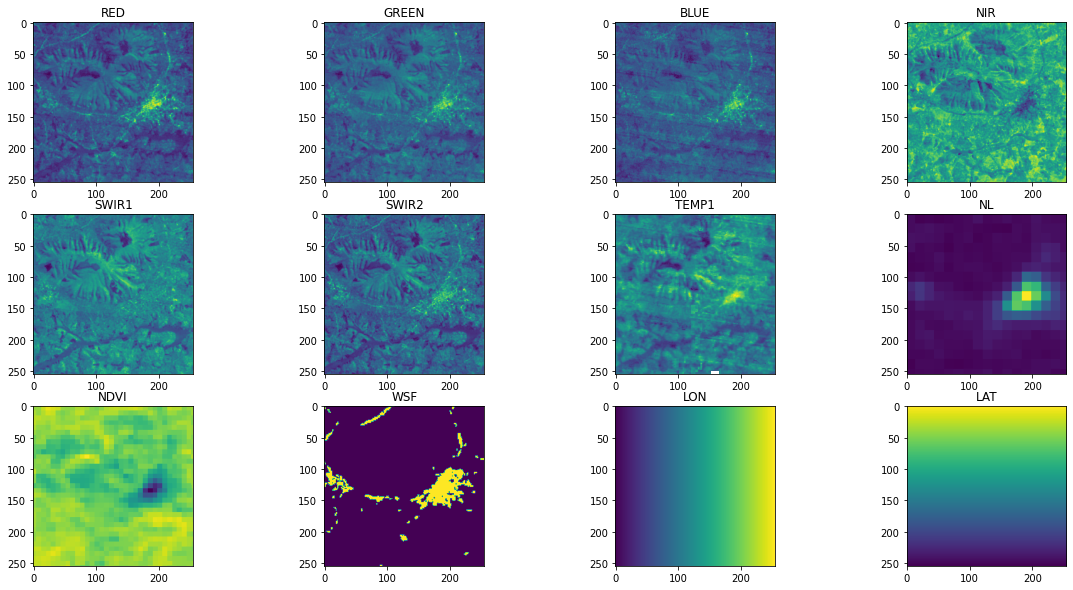

In [ ]:
# plot the image
img_bands = ['RED', 'GREEN', 'BLUE', 'NIR', 'SWIR1', 'SWIR2', 'TEMP1', 'NL', 'NDVI', 'WSF', 'LON', 'LAT']
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 10))
for i, ax in enumerate(axs.flat):
  ax.imshow(ex_img[:,:,i])
  ax.set_title(img_bands[i])
plt.show()

## add visualisation parameters for all images
